**Simulated Annealing for the predator-prey model**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

data = df
print(data)

    Unnamed: 0          t         x         y
0            0   0.000000  4.781635  3.035257
1            1   0.202020  6.114005  2.189746
2            2   0.404040  6.238361  1.478907
3            3   0.606061  5.520524  0.989836
4            4   0.808081  4.582546  0.957827
..         ...        ...       ...       ...
95          95  19.191919  0.310346  1.241890
96          96  19.393939  0.324595  1.437257
97          97  19.595960  0.258083  1.562810
98          98  19.797980  0.283680  1.834171
99          99  20.000000  0.135956  2.147065

[100 rows x 4 columns]


In [3]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params, data):
    x = data['x']
    y = data['y']
    x_and_y = np.vstack((x,y)).T
    t = np.array(data['t'])
    
    y0 = [x[0], y[0]]
    time = np.linspace(t[0],t[-1],len(t))
    model = odeint(lotka_volterra, y0, time, args=(params[0], params[1], params[2], params[3]))
    return np.linalg.norm(model - x_and_y)**2

In [4]:
def simulated_annealing(init_guess, T_start, T_end, std, min_function, b, data):
    """"
    Performs simulated annealing to find global optimal values.
    init_guess = initial guess (tuple of four real numbers, indicating alpha, beta, delta, gamma)
    T_start, T_end = starting temperature and ending temperature
    std = standard deviation of the normal distribution that determines new possible solutions
    min_function = objective function (to be minimized)
    b = variable for the cooling schedule
    data = the data to be fitted
    """
    T = T_start
    a = T_start * np.log(1 + b)
    prev_sol = init_guess
    n = 0 # count the number of iterations

    while T > T_end:
        # create a new solution
        new_sol = []
        for param in prev_sol:
            new_param = param + np.random.normal(0,std)
            new_sol.append(new_param)

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < min(np.exp((-min_function(new_sol,data)+min_function(prev_sol,data))/T),1):
            prev_sol = new_sol
        
        # decrease the temperature
        n += 1
        T = a/np.log(n + b)
        print(T)

    return prev_sol


In [5]:
init_guess = np.ones(4)
b = 10
T_start = 20
T_end = 5
std = 0.1
min_function = abs_residual
data = df

params = simulated_annealing(init_guess, T_start, T_end, std, min_function, b, data)

20.0
19.299680919626876
18.697408319761173
18.172362122561044
17.70938568142051
17.29715809318649
16.92703641841094
16.592296587783874
16.287620764191935
16.008742129373427
15.752193139305124
15.51512351564849
15.295166297015768
15.090337677104984
14.898961024049783
14.719608488056165
14.551055590960921
14.392245526804667
14.242260816199227
14.10030059253148
13.965662246303474
13.83772647454919
13.715945014531371
13.599830511143653
13.48894809355931
13.382908331057726
13.281361309276763
13.183991622503518
13.090514119404087
13.000670271966595
12.914225062697847
12.830964304970713
12.75069232712815
12.673229963454657
12.598412805139713
12.526089672421481
12.456121275627645
12.38837903814251
12.32274405867344
12.259106193757857
12.197363244396426
12.137420233137435
12.079188759967188
12.022586427056213
11.967536323832107
11.913966565045367
11.861809875503647
11.811003216004664
11.761487445724187
11.713207016934474
11.666109698457424
11.620146324710346
11.5752705675918
11.531438728790992


In [6]:
print(params)

[3.7036881666700934, 1.4677222148070572, 0.14377087719921805, 0.3522499016641686]


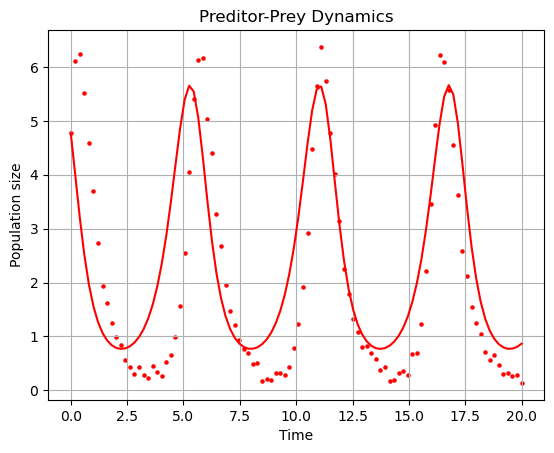

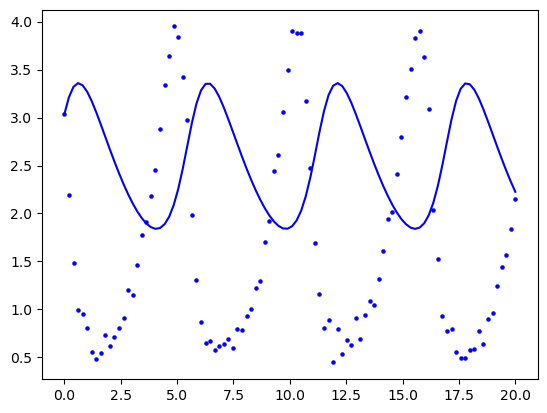

In [7]:
alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()

**Stochastic hill climbing**

Chooses at random from uphill moves (steepness determines probability of selection)

In [96]:
def stoch_hill_climb(init_guess, std, min_function, data, n_iterations):
    prev_sol = init_guess

    for _ in range(n_iterations):
        # create a new solution
        new_sol = []
        for param in prev_sol:
            new_param = param + np.random.normal(0,std)
            new_sol.append(new_param)

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
            prev_sol = new_sol

    return prev_sol

In [99]:
init_guess = np.ones(4)
std = 0.1
min_function = abs_residual
data = df
n_iterations = 10000

params_shc = stoch_hill_climb(init_guess,std,min_function,data,n_iterations)

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: overflow encountered in exp
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: invalid value encountered in scalar divide
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):


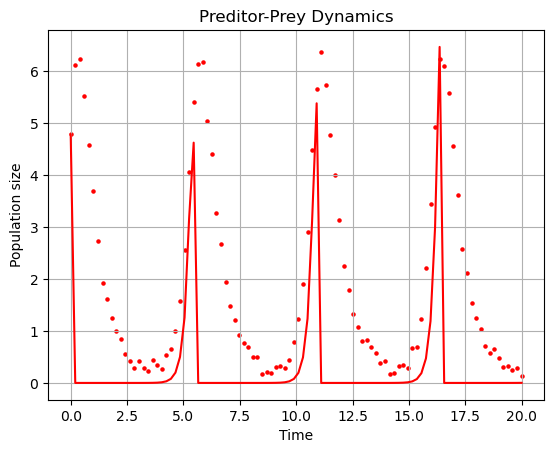

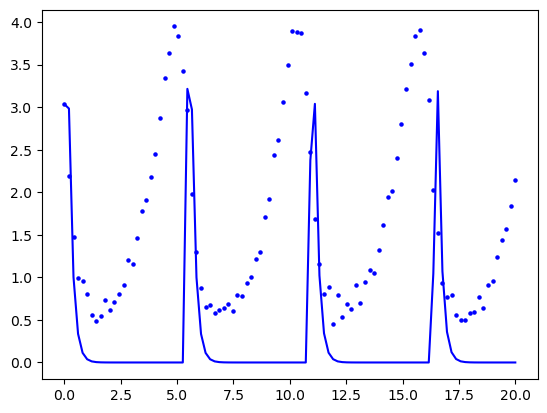

In [100]:
alpha_shc = params_shc[0]
beta_shc = params_shc[1]
delta_shc = params_shc[2]
gamma_shc = params_shc[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output_shc = odeint(lotka_volterra, y0, t, args=(alpha_shc, beta_shc, delta_shc, gamma_shc))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()